In [1]:
import numpy as np
import cvxpy as cp
import osbdo as ob

# Problem description
section 4.1 in https://web.stanford.edu/~boyd/papers/os_bundle_distr_opt.html 

# Create parameters

In [2]:
ms = [20,30,40,25,35]
ns = [30,40,25,35,20]
params = ob.sc_params(ms, ns)

# Distributed solution

In [3]:
agents = ob.sc_agents(params)
g = ob.sc_coupling(params, agents)
prob = ob.Problem(agents = agents, g = g)

In [4]:
x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=150)

k=0, rel_gap=inf, L=-2259.45928101545, U=5433.21717144344
k=1, rel_gap=inf, L=-1673.3332404236116, U=5433.21717144344
k=2, rel_gap=inf, L=-1598.7998236974145, U=3163.4025889241566
k=3, rel_gap=inf, L=-1489.4775112770903, U=2477.0461251092515
k=4, rel_gap=inf, L=-983.2346825705504, U=1362.7774635378437
k=5, rel_gap=inf, L=-809.5629872596187, U=1362.7774635378437
k=6, rel_gap=inf, L=-717.0900397344624, U=670.5066906714421
k=7, rel_gap=inf, L=-624.3270063460825, U=244.13845969933686
k=8, rel_gap=inf, L=-585.0077239183856, U=139.92446398497827
k=9, rel_gap=inf, L=-491.864348152038, U=93.92582331993094
k=10, rel_gap=inf, L=-406.5156674614118, U=48.13625270157854
k=11, rel_gap=inf, L=-363.31676670832394, U=48.13625270157854
k=12, rel_gap=inf, L=-296.08857641726945, U=48.13625270157854
k=13, rel_gap=56.56459935058561, L=-266.093754691766, U=-4.622524219636716
k=14, rel_gap=11.869515848166529, L=-205.59261704118808, U=-15.975163282500489
k=15, rel_gap=1.9505218038896164, L=-191.6403297659822, 

k=108, rel_gap=0.012139385375981393, L=-96.0819365357861, U=-94.92955014303129
k=109, rel_gap=0.010166677105443188, L=-95.94541058837376, U=-94.97978181511405
k=110, rel_gap=0.008979099743400982, L=-95.83261474963842, U=-94.97978181511405
k=111, rel_gap=0.008462015392659073, L=-95.78350219082495, U=-94.97978181511405
k=112, rel_gap=0.008157191603840213, L=-95.75455009387088, U=-94.97978181511405
k=113, rel_gap=0.0079984166517853, L=-95.739469683567, U=-94.97978181511405
k=114, rel_gap=0.007706492365876207, L=-95.71350706222233, U=-94.98153260629272
k=115, rel_gap=0.007061745212831671, L=-95.6588876729445, U=-94.98810587103378
k=116, rel_gap=0.006693904715792461, L=-95.62394720086809, U=-94.98810587103378
k=117, rel_gap=0.006240827573237321, L=-95.60820361183346, U=-95.01522994491575
k=118, rel_gap=0.0059460733676202525, L=-95.58019747320952, U=-95.01522994491575
k=119, rel_gap=0.005848469687430739, L=-95.57092363709285, U=-95.01522994491575
k=120, rel_gap=0.005718884401223204, L=-95.55

# Centralized solution

In [5]:
h_cvx, x_cvx, prob_cvx = ob.cvx_supply_chain(params=params)

In [6]:
h_cvx, prob.upper_bnd[-1]

(-95.08756270344816, -95.06695749274087)

# Plot

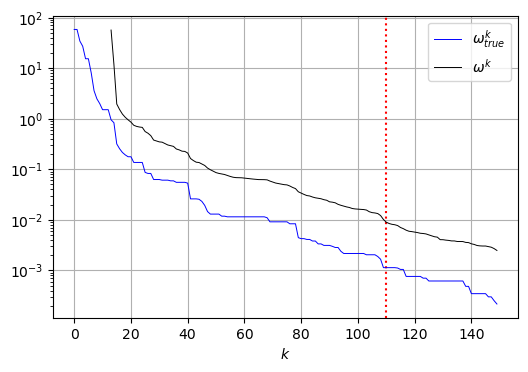

In [7]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx)